In [60]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor



# Utils

In [61]:
# Utils 


# ------------------ mortality model ------------------
def get_annual_death_rate(age):
    if age < 1:
        death_rate = 0.2
    elif age < 5:
        death_rate = 0.1
    elif age < 15:
        death_rate = 0.001
    elif age < 25:
        death_rate = 0.001
    elif age < 35:
        death_rate = 0.0015
    elif age < 45:
        death_rate = 0.0025
    elif age < 55:
        death_rate = 0.007
    elif age < 65:
        death_rate = 0.018
    elif age < 75:
        death_rate = 0.04
    elif age < 85:
        death_rate = 0.10
    else:
        death_rate = 0.20
    return death_rate





def get_alive_prob(max_age=105, precision=1000):
    """
    Computes expected age at death for each current age 0..max_age
    using the get_death_rate function and assuming Poisson-like discrete mortality.
    """


    dt = 1/precision
    age_list = np.arange(0, max_age + dt, dt)
    alive_prob = np.ones_like(age_list)


    for i in range(1, len(age_list)):
        age = int(age_list[i])
        alive_prob[i] = alive_prob[i-1] * (1 - get_annual_death_rate(age) * dt)

        if alive_prob[i] < 1e-12:
            alive_prob[i:] = 0.0
            break
    alive_prob[-1] = 0
    return age_list, alive_prob


def calculate_expected_death_age(age_list, alive_prob):
    """
    age_list   : increasing list of ages (fine grid)
    alive_prob : alive_prob[i] = P(T >= age_list[i])

    returns:
        dict {current_age: expected_age_of_death}
    """
    age_list = np.asarray(age_list)
    alive_prob = np.asarray(alive_prob)

    expected_death_age = {}

    # grid step (assumed uniform)
    dt = age_list[1] - age_list[0]

    # cumulative integral of survival from the end
    # integral_S[i] = ∫_{age_list[i]}^∞ S(t) dt
    integral_S = np.cumsum(alive_prob[::-1])[::-1] * dt

    for i, age in enumerate(age_list):
        S_a = alive_prob[i]

        if S_a < 1e-12:
            expected_death_age[age] = np.nan
        else:
            expected_death_age[age] = age + integral_S[i] / S_a

    return expected_death_age




def sample_from_cdf(x, cdf):
    u = np.random.rand()
    idx = np.where(cdf < u)[0][0]
    return x[idx]



def generate_data(nb_data = 300):

    age_list, alive_prob =  get_alive_prob(max_age=105)

    X = np.random.choice(age_list, nb_data, p=alive_prob/np.sum(alive_prob))
    X.sort()

    y = np.ones(len(X))

    for i in range(len(X)):
        x = X[i]
        index = np.where(age_list==x)[0][0]
        n_alive_prob = alive_prob[index::]/ alive_prob[index::][0]
        n_age_list = age_list[index::]
        death_year_x = sample_from_cdf(n_age_list, n_alive_prob)
        y[i]  = death_year_x
        
    
    life_exp_dict  = calculate_expected_death_age(age_list, alive_prob)
    return np.asarray(X).reshape(-1, 1), np.asarray(y), life_exp_dict



# Generate Data

In [62]:
# ------------------ data generation step------------------
np.random.seed(42)
X, y, life_exp = generate_data(nb_data= 300)

# ------------------ train / test split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

x_plot = np.sort(X_test.copy().T[0])



# First Model

265.259641317161
256.9662638905596


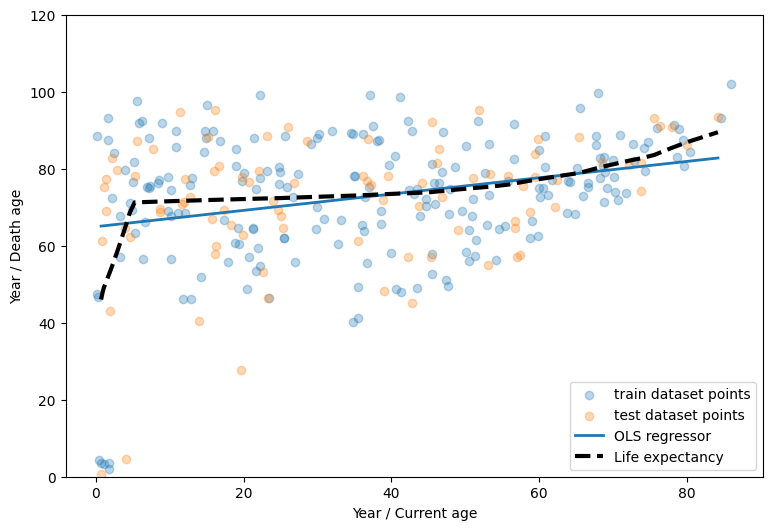

In [63]:

# Training step
model = LinearRegression(fit_intercept=True)


    
model.fit(X_train, y_train)
train_error = (y_train - model.predict(X_train))**2
mean_train_error = np.mean(train_error)
print(mean_train_error)


#test step



test_error  = (y_test - model.predict(X_test))**2
mean_test_error = np.mean(test_error) 
print(mean_test_error)


# print(model.predict([ [0]]))
# print(model.predict([[105]]))


# alpha = 0.05
# a = 0
# b = 7603.84
# M = len(y_test)
# epsilon = (b-a)*np.sqrt((np.log(2/alpha))/(2*M))
# print(epsilon)



plt.figure(figsize=(9, 6))

plt.scatter(X_train, y_train,  alpha=0.3, label = "train dataset points")
plt.scatter(X_test, y_test,  alpha=0.3, label = "test dataset points")

y_plot = model.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_plot, linewidth=2, label=f"OLS regressor")

# life expectancy curve
plt.plot(
    x_plot,
    [life_exp[i]for i in x_plot],
    linewidth=3,
    linestyle="--",
    label="Life expectancy",
    color='black'
)

plt.ylim(0, 120)
# ------------------ plot formatting ------------------
plt.xlabel("Year / Current age")
plt.ylabel("Year / Death age")
# plt.title("Ordinary Least Squares on training data and life expectancy curve")
plt.legend()
plt.show()

# polynomial regressions Pseudoinverse Method

In [64]:
# ------------------ polynomial Pseudoinverse Method ------------------


degree_list = [ 1, 2, 3, 5, 10, 25]
pseudoinv_model_list = []

# regression curves
for degree in degree_list:

    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scaler", StandardScaler()),
        ("linreg",  LinearRegression(fit_intercept=True))
    ])

    
    model.fit(X_train, y_train)
    train_error = np.mean((y_train - model.predict(X_train))**2)
    print(np.mean((y_train - model.predict(X_train))**2))
    print(np.mean((y_test - model.predict(X_test))**2))
    print()
    pseudoinv_model_list.append(model)
    
 

265.259641317161
256.9662638905596

265.0277168672208
256.39029680289303

247.04871485088628
247.34074135440903

232.3079328217823
251.08360443618048

217.78614431588767
241.72074920569753

188.66417549303677
460.05020565733616



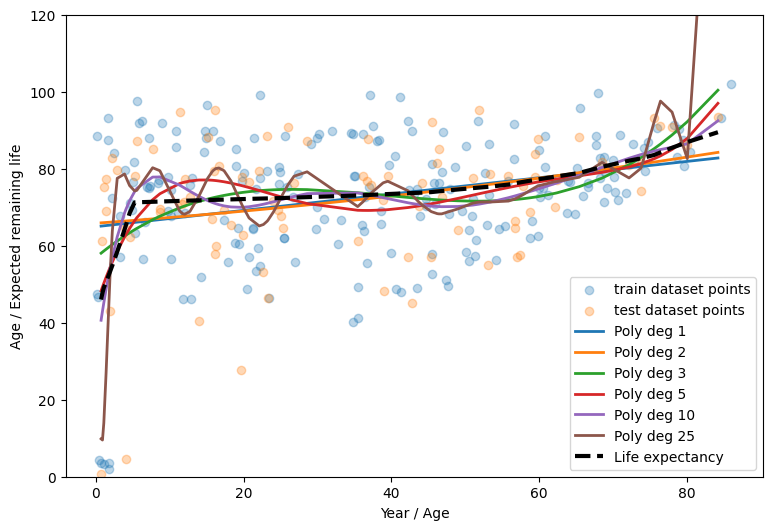

In [65]:

plt.figure(figsize=(9, 6))

plt.scatter(X_train, y_train,  alpha=0.3, label = "train dataset points")
plt.scatter(X_test, y_test,  alpha=0.3, label = "test dataset points")

for degree, model in zip(degree_list, pseudoinv_model_list):
    y_plot = model.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, linewidth=2, label=f"Poly deg {degree}")

# life expectancy curve
plt.plot(
    x_plot,
    [life_exp[i]for i in x_plot],
    linewidth=3,
    linestyle="--",
    label="Life expectancy",
    color='black'
)

plt.ylim(0, 120)
# ------------------ plot formatting ------------------
plt.xlabel("Year / Age")
plt.ylabel("Age / Expected remaining life")
# plt.title("Polynomial regression (SGD) and life expectancy curve")
plt.legend()
plt.show()


# polynomial regressions SGD regression Method

In [66]:
# ------------------ polynomial SGD regression ------------------


sgd_model_list = []
# regression curves
for degree in degree_list:
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scaler", StandardScaler()),
        ("sgd", SGDRegressor(
            loss="squared_error",
            max_iter=5000000,
            tol=None,
            random_state=42,
            fit_intercept=True
        ))
    ])



    
    model.fit(X_train, y_train)
    print(np.mean((y_train - model.predict(X_train))**2))
    print(np.mean((y_test - model.predict(X_test))**2))
    print()
    sgd_model_list.append(model)
    
 

265.2596439770341
256.9674921840063

265.02772391733714
256.3925211491317

247.11842265102604
246.70825350815846

242.6140527544907
246.0448810244386

241.66110904951256
246.86909651167085

241.80361219086308
247.2718088991566



In [67]:

# nb_iter= 5000000

# 265.2596439770341
# 256.9674921840063

# 265.02772018554833
# 256.39031041873034

# 247.0487310766559
# 247.33050502809843

# 232.30907850590884
# 250.9628715846882

# 218.31687985525846
# 242.00154394638548

# 218.21662465809433
# 241.97294499537668

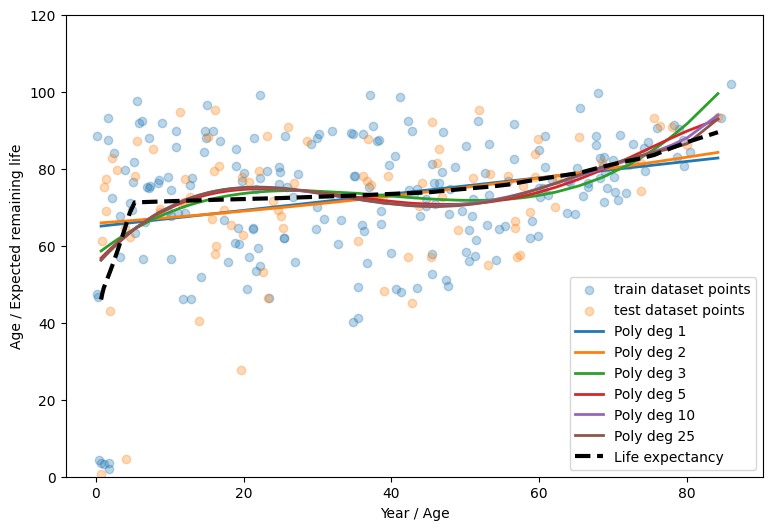

In [68]:
plt.figure(figsize=(9, 6))

plt.scatter(X_train, y_train,  alpha=0.3, label = "train dataset points")
plt.scatter(X_test, y_test,  alpha=0.3, label = "test dataset points")

for degree, model in zip(degree_list, sgd_model_list):
    y_plot = model.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, linewidth=2, label=f"Poly deg {degree}")

# life expectancy curve
plt.plot(
    x_plot,
    [life_exp[i]for i in x_plot],
    linewidth=3,
    linestyle="--",
    label="Life expectancy",
    color='black'
)

plt.ylim(0, 120)
# ------------------ plot formatting ------------------
plt.xlabel("Year / Age")
plt.ylabel("Age / Expected remaining life")
# plt.title("Polynomial regression (SGD) and life expectancy curve")
plt.legend()
plt.show()


# Deep and Shallow Neural Network

In [ ]:
from sklearn.preprocessing import StandardScaler


# # ------------------ feedforward shallow neural network ------------------
nn_model_shallow =  Pipeline([
        ("input", PolynomialFeatures(degree=1, include_bias=False)),
        ("mlp", MLPRegressor(
            hidden_layer_sizes=(320),  
            activation='relu',
            solver='adam',               
            max_iter=5000000,
            random_state=42
        ))
    ])
    
nn_model_shallow.fit(X_train, y_train)

print(np.mean((y_train - nn_model_shallow.predict(X_train))**2))
# print(np.mean((y_test - nn_model_shallow.predict(X_test))**2))
print()

# # ------------------ feedforward deep neural network ------------------

nn_model_deep =  Pipeline([
        ("input", PolynomialFeatures(degree=1, include_bias=False)),
        ("mlp", MLPRegressor(
            hidden_layer_sizes=(10000, 10000, 10000, 10000),  
            activation='relu',
            solver='adam',                
            max_iter=50000000,
            random_state=42
        ))
    ])
    
nn_model_deep.fit(X_train, y_train)

print(np.mean((y_train - nn_model_deep.predict(X_train))**2))
print(np.mean((y_test - nn_model_deep.predict(X_test))**2))
print()


264.6000918476045
256.2907145099564



MemoryError: Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64

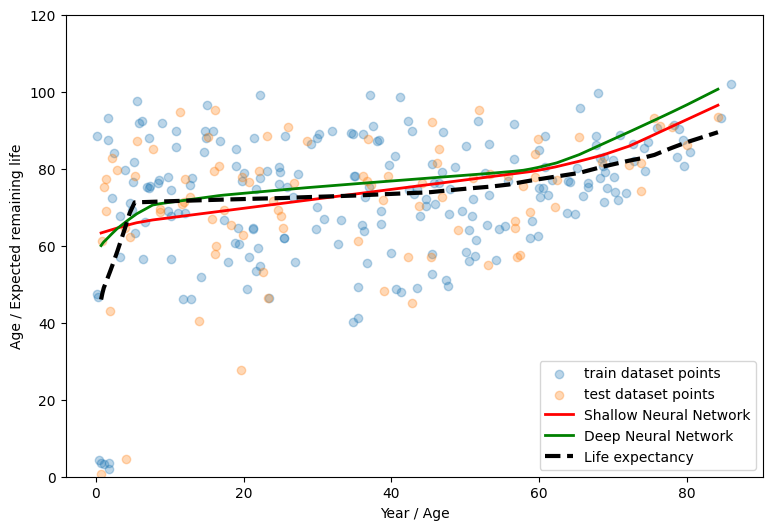

In [77]:

# ------------------ plot ------------------
plt.figure(figsize=(9, 6))
plt.scatter(X_train, y_train,  alpha=0.3, label = "train dataset points")
plt.scatter(X_test, y_test,  alpha=0.3, label = "test dataset points")


y_nn_plot = nn_model_shallow.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_nn_plot, linewidth=2, color='red', label="Shallow Neural Network")

y_nn_plot = nn_model_deep.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, y_nn_plot, linewidth=2, color='green', label="Deep Neural Network")

# life expectancy curve
plt.plot(
    x_plot,
    [life_exp[i]for i in x_plot],
    linewidth=3,
    linestyle="--",
    label="Life expectancy",
    color='black'
)

plt.ylim(0, 120)
plt.xlabel("Year / Age")
plt.ylabel("Age / Expected remaining life")
# plt.title("Neural Network, and life expectancy curve")
plt.legend()
plt.show()
